In [81]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import cartopy.crs as ccrs
import cartopy
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.cluster import KMeans
from itertools import groupby
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import seaborn as sns
from tqdm import tqdm
from statsmodels.tsa.ar_model import AutoReg

In [5]:
ds_solar = xr.open_dataset('../data/Solar_forcing_1st_mill.nc')
ds_volc = xr.open_dataset('../data/Volc_Forc_AOD_1st_mill.nc')
ds_temp_r1 = xr.open_dataset('../data/T2m_R1_ym_1stMill.nc')
ds_temp_r2 = xr.open_dataset('../data/T2m_R2_ym_1stMill.nc')

temp_r1 = ds_temp_r1['T2m'].values
temp_r2 = ds_temp_r2['T2m'].values

mean_temp_r1 = np.mean(np.mean(temp_r1, axis=1), axis=1)
mean_temp_r2 = np.mean(np.mean(temp_r2, axis=1), axis=1)

Model:r1, lag: 1, pearson: (0.712388538697566, 1.6405276612822461e-155)
Model:r2, lag: 1, pearson: (0.7109186307778667, 1.3601737611555903e-154)
Model:r1, lag: 2, pearson: (0.526213630657352, 3.09272790366278e-72)
Model:r2, lag: 2, pearson: (0.5125485703472155, 5.133515113836178e-68)
Model:r1, lag: 3, pearson: (0.4284233830987755, 7.353647508939624e-46)
Model:r2, lag: 3, pearson: (0.40892417413574755, 1.4904419003259821e-41)
Model:r1, lag: 4, pearson: (0.34295897316772633, 5.931617759615519e-29)
Model:r2, lag: 4, pearson: (0.3174570814018227, 7.932744454430015e-25)
Model:r1, lag: 5, pearson: (0.2548135353355211, 2.8577294721251243e-16)
Model:r2, lag: 5, pearson: (0.2615756461144366, 4.3150060824102025e-17)
Model:r1, lag: 6, pearson: (0.1818536394057624, 7.081499150164357e-09)
Model:r2, lag: 6, pearson: (0.2306359867383185, 1.5793667527509014e-13)
Model:r1, lag: 7, pearson: (0.11823341805496534, 0.00018006001334507665)
Model:r2, lag: 7, pearson: (0.18344800918020154, 5.201034120383415e-

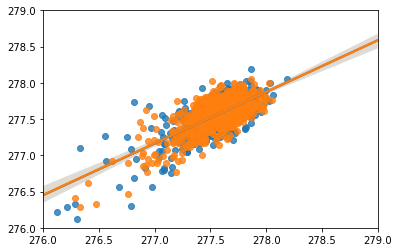

In [40]:
for s in range(1, 10):
    print(f'Model:r1, lag: {s}, pearson: {pearsonr(mean_temp_r1, np.roll(mean_temp_r1, s))}')
    print(f'Model:r2, lag: {s}, pearson: {pearsonr(mean_temp_r2, np.roll(mean_temp_r2, s))}')
    
plt.figure()
plt.xlim(276, 279)
plt.ylim(276, 279)
sns.regplot(x=mean_temp_r1, y=np.roll(mean_temp_r1, 1), truncate=False)
sns.regplot(x=mean_temp_r2, y=np.roll(mean_temp_r2, 1), truncate=False)
plt.show()

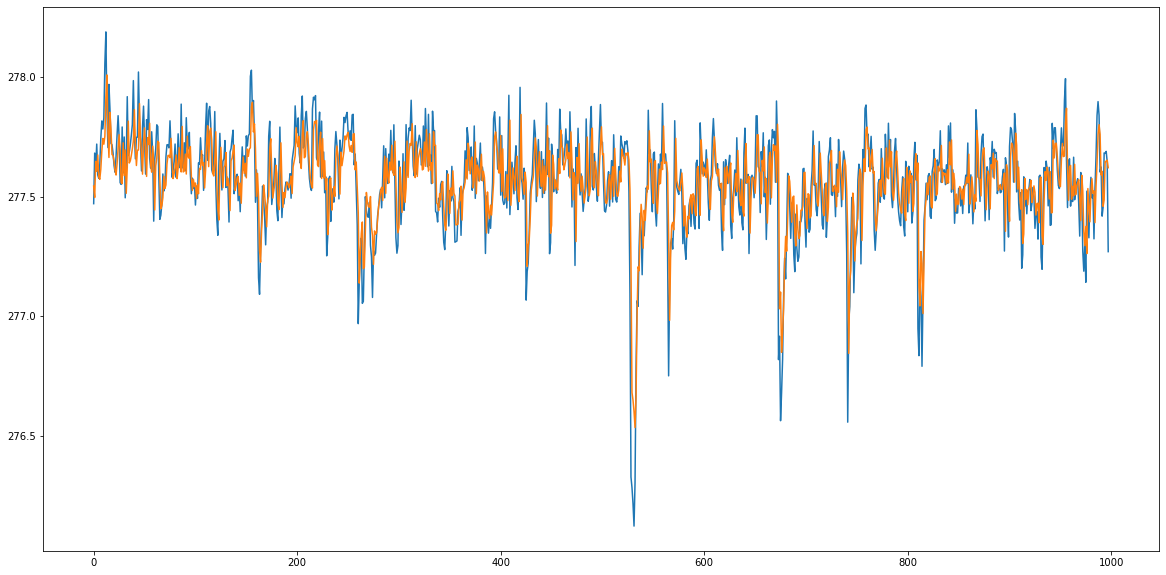

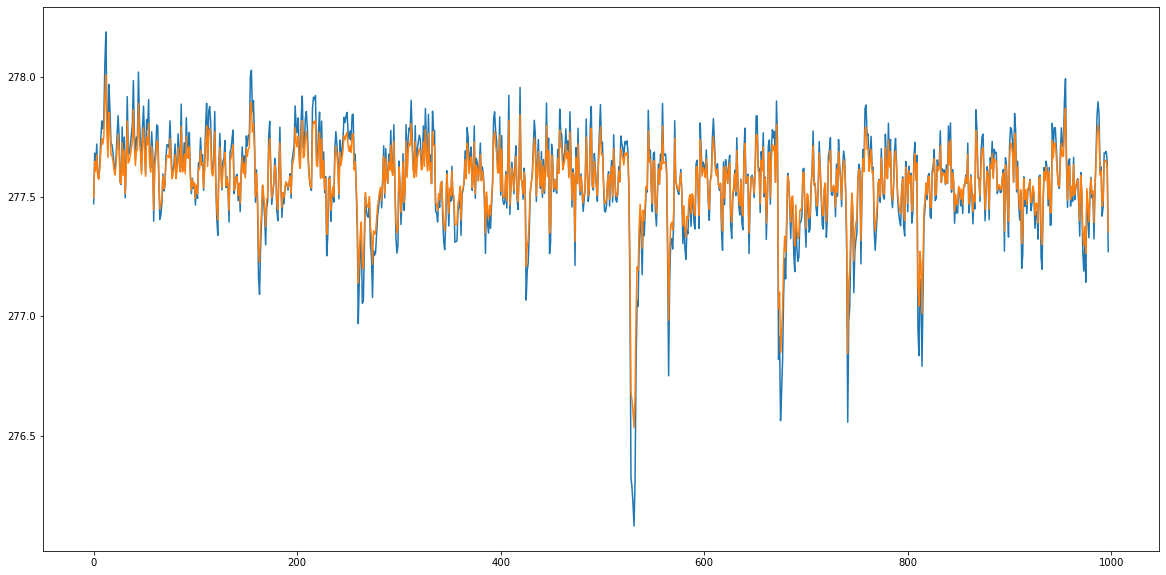

'plt.figure(figsize=(20, 10))\nplt.plot(ds_volc.AOD.values.flatten()[1:])\n#plt.plot((model.predict() - mean_temp_r1[1:]))\nvolcanic_binary_eruption = np.zeros((model.predict() - mean_temp_r1[1:]).shape)\nvolcanic_binary_eruption[np.abs(model.predict() - mean_temp_r1[1:]) > 0.3] = 0.5\nplt.plot(volcanic_binary_eruption)\nplt.show()'

In [113]:
model = AutoReg(mean_temp_r1, lags=1).fit()
beta_1, beta_2 = model.params

# comparison to actual data:
plt.figure(figsize=(20, 10))
plt.plot(mean_temp_r1[1:])
plt.plot(model.predict())
plt.show()

# check whether for loop works:
predicted_temp = []
for i in np.arange(1, 999):
    predicted_temp.append(beta_1 + beta_2*mean_temp_r1[i])
plt.figure(figsize=(20, 10))
plt.plot(mean_temp_r1[1:])
plt.plot(predicted_temp)
plt.show()

# volcanic eruption detection?
'''plt.figure(figsize=(20, 10))
plt.plot(ds_volc.AOD.values.flatten()[1:])
#plt.plot((model.predict() - mean_temp_r1[1:]))
volcanic_binary_eruption = np.zeros((model.predict() - mean_temp_r1[1:]).shape)
volcanic_binary_eruption[np.abs(model.predict() - mean_temp_r1[1:]) > 0.3] = 0.5
plt.plot(volcanic_binary_eruption)
plt.show()'''

In [49]:
# choose AR(1) to generate random time series. For initialization use linear regression of beta_1 and beta_2 params
beta_2 = []
beta_1 = []

reg = LinearRegression().fit(mean_temp_r1.reshape(-1,1), np.roll(mean_temp_r1, 1))
print('score: ', reg.score(mean_temp_r1.reshape(-1,1), np.roll(mean_temp_r1, 1)))
beta_2.append(reg.coef_)
beta_1.append(reg.intercept_)

reg = LinearRegression().fit(mean_temp_r2.reshape(-1,1), np.roll(mean_temp_r2, 1))
print('score: ', reg.score(mean_temp_r2.reshape(-1,1), np.roll(mean_temp_r2, 1)))
beta_2.append(reg.coef_)
beta_1.append(reg.intercept_)

beta_2 = np.mean(beta_2)
beta_1 = np.mean(beta_1)
print(beta_1, beta_2)

# find std in beta_1 and beta_2:
cov_matrix = np.sqrt(np.cov(np.array([mean_temp_r1, np.roll(mean_temp_r1, 1)])))
sigma_1 = cov_matrix[1, 1]
sigma_2 = cov_matrix[0, 1]
#sigma_epsilon = np.mean([np.std(temp_r1), np.std(temp_r2)])
mean_temp_first_year = np.mean([np.mean(temp_r1[0,:,:]), np.mean(temp_r2[0,:,:])])
std_temp_first_year = np.mean([np.std(temp_r1[0,:,:]), np.std(temp_r2[0,:,:])])

score:  0.5074950929788454
score:  0.5054037650030634
80.03488 0.71165365


In [174]:
# create 1000 random time series according to: temp = beta_1 + beta_2*yr + epsilon

n_time_series = 1000

np.random.seed(42)
random_beta_1 = np.random.normal(loc=beta_1, scale=sigma_1**2, size=n_time_series)
random_beta_2 = np.random.normal(loc=beta_2, scale=sigma_2**4, size=n_time_series)
epsilon_init = np.random.normal(loc=0, scale=0.5, size=(n_time_series, 998))
#epsilon_pred = np.random.normal(loc=0, scale=0.1, size=(n_time_series, 998))

ts_list = np.zeros((998, n_time_series))
for ts in np.arange(n_time_series):
    ts_list[:, ts] = mean_temp_r1[:998] + epsilon_init[ts, :]
    ts_list[:, ts] = random_beta_1[ts] + random_beta_2[ts]*ts_list[:, ts]
print(ts_list.shape)

(998, 1000)


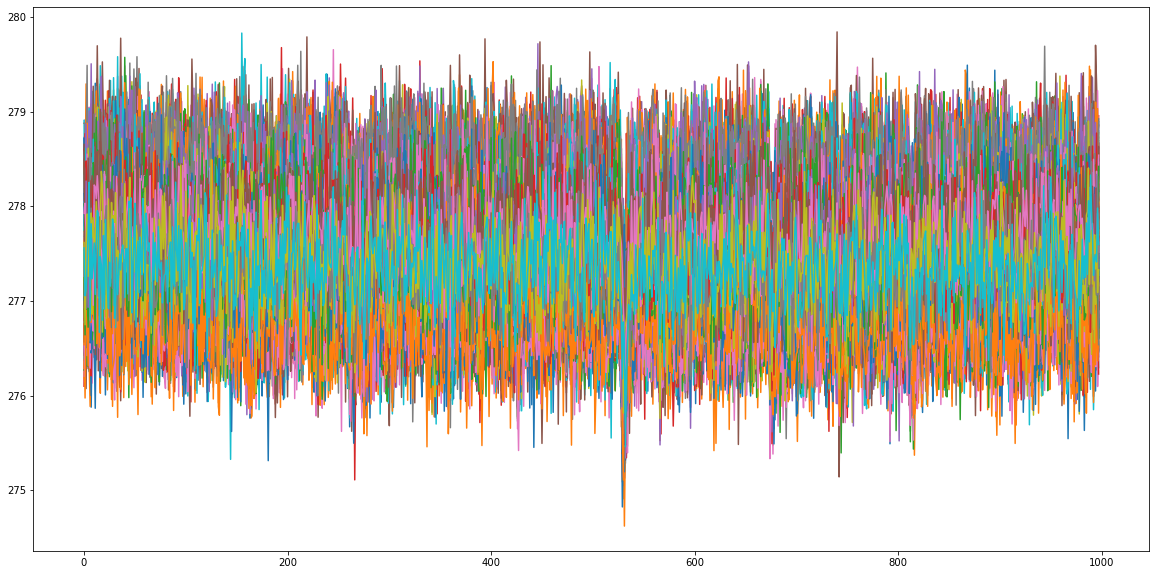

In [175]:
plt.figure(figsize=(20,10))
for i in np.arange(n_time_series):
    plt.plot(ts_list[:, i])
plt.show()

In [176]:
# check how the correlation looks like after smoothing:

def smooth_butter(data):
    # Butterworth filter settings
    cutoff = 0.125   # Hz
    order = 8
    [b, a] = signal.butter(order, cutoff)   # The second parameter is a normed value in [0;1] where 1 is the Nyquist frequency, i.e. half of the sampling rate. In the case of 25 FPS, this means that 1 = 12.5 Hz and hence 0.08 = 1 Hz

    # axis = 0 means that the filter is applied on each column
    data = signal.filtfilt(b, a, data, method='gust')

    return data

smoothed_sol = smooth_butter(ds_solar.TSI.values.flatten())
smoothed_vol =smooth_butter(ds_volc.AOD.values.flatten())

smoothed_random_series = ts_list.copy()
pearson_coeffs_sol = []
pearson_coeffs_vol = []
for i in np.arange(n_time_series):
    smoothed_random_series[:, i] = smooth_butter(smoothed_random_series[:, i])
    pearson_coeffs_sol.append(pearsonr(smoothed_random_series[:, i], smoothed_sol[1:])[0])
    pearson_coeffs_vol.append(pearsonr(smoothed_random_series[:, i], smoothed_vol[1:])[0])
#print(np.mean(pearson_coeffs_sol))
print(np.max(pearson_coeffs_sol), np.min(pearson_coeffs_vol))
#print(pearson_coeffs)


0.3998539728042009 -0.5603667529799664
